<a href="https://colab.research.google.com/github/Lisankk/Dirisl_Phase2_PJT/blob/minami_branch/%E3%82%AF%E3%83%BC%E3%83%9D%E3%83%B3%E3%81%82%E3%82%8A%E3%83%A2%E3%83%87%E3%83%AB_(CV%E3%81%82%E3%82%8A)_%E3%81%AE%E3%81%A4%E3%81%A5%E3%81%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import scipy as sp
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#csvファイルの読み込み
df = pd.read_csv('/content/drive/MyDrive/Dirisl-Phase2/data/abtest_results_for_coupon_sending.csv')
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,area_classification,newbie,channel,segment,visit,conversion,spend
0,男性,6,32908,1,1,地方,1,ウェブ,送付なし,0,0,0
1,男性,9,67583,1,0,地方,1,ウェブ,送付あり,0,0,0
2,女性,9,67507,1,1,地方,1,スマートフォン,送付あり,0,0,0
3,男性,2,10164,0,1,都会,0,ウェブ,送付あり,1,0,0
4,女性,4,24142,0,1,地方,1,複数,送付なし,0,0,0


In [36]:
df["sex"] = df["sex"].map({"男性": 0, "女性": 1})
# df["area_classification"] = df["area_classification"].map({"都会": 0, "郊外": 1, "地方": 2})
df["segment"] = df["segment"].map({"送付あり": 0, "送付なし": 1})
# df["channel"] = df["channel"].map({"ウェブ": 0, "スマートフォン": 1, "複数": 2})

In [37]:
df_onehot = pd.get_dummies(df[["area_classification", "channel"]], dtype=int)
df = pd.concat([df, df_onehot], axis=1)
df = df.drop(["area_classification", "channel"], axis=1)
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,newbie,segment,visit,conversion,spend,area_classification_地方,area_classification_郊外,area_classification_都会,channel_ウェブ,channel_スマートフォン,channel_複数
0,0,6,32908,1,1,1,1,0,0,0,1,0,0,1,0,0
1,0,9,67583,1,0,1,0,0,0,0,1,0,0,1,0,0
2,1,9,67507,1,1,1,0,0,0,0,1,0,0,0,1,0
3,0,2,10164,0,1,0,0,1,0,0,0,0,1,1,0,0
4,1,4,24142,0,1,1,1,0,0,0,1,0,0,0,0,1


In [38]:
# ラベルエンコーディング(LabelEncoder)
# from sklearn.preprocessing import OrdinalEncoder

# oe = OrdinalEncoder()
# encoded = oe.fit_transform(df[['area_classification', 'channel']].values)
# encoded = pd.DataFrame(encoded, columns=['encode_area_classification', 'encode_channel'])
# df = pd.concat([df, encoded], axis=1)
# df = df.drop(['area_classification', 'channel'], axis=1)
# df.head()

In [39]:
df_RF = df[["recency", "history", "newbie", "segment", "visit"]]
df_RF

,recency,history,newbie,segment,visit
0,6,32908,1,1,0
1,9,67583,1,0,0
2,9,67507,1,0,0
3,2,10164,0,0,1
4,4,24142,1,1,0
...,...,...,...,...,...
42608,7,8646,0,0,1
42609,10,10554,0,0,1
42610,5,3890,1,0,0
42611,6,2999,1,0,1


**ランダムフォレストの実装に当たってクーポンありとなしのグループに分ける**

In [40]:
df_RF_YesKoupon = df_RF[df_RF["segment"] == 0]
df_RF_NoKoupon = df_RF[df_RF["segment"] == 1]

In [41]:
df_RF_YesKoupon = df_RF_YesKoupon.drop("segment", axis = 1)
df_RF_NoKoupon = df_RF_NoKoupon.drop("segment", axis = 1)



---
以下より、同じくクーポンありモデルについて、交差検証ありのRandom Forestの実装を進めていく。


**交差検証の実装(クーポンあり)**

In [42]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42,
                               criterion='entropy',
                               max_depth=5,
                               max_features=None,
                               n_estimators=150)


# 説明変数と目的変数の定義
X = df_RF_YesKoupon[["recency", "history", "newbie"]]
y = df_RF_YesKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross validation scores: {scores.mean()}')

Cross validation scores: 0.9426033571351109


交差検証の実装(クーポンなし)

In [43]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42,
                               criterion='entropy',
                               max_depth=5,
                               max_features=None,
                               n_estimators=70)


# 説明変数と目的変数の定義
X = df_RF_NoKoupon[["recency", "history", "newbie"]]
y = df_RF_NoKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross validation scores: {scores.mean()}')

Cross validation scores: 0.7267119318055959


**oof算出処理の実装**

In [50]:

Z = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
  # oof予測値を格納する配列
  oof_predictions = np.zeros(X.shape[0])
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

# モデル学習
  model.fit(X_train, y_train)

# oof予測値の保存
  oof_predictions = model.predict_proba(X_val)[:, 1]
  oof_predictions = pd.DataFrame(oof_predictions)


# OOFスコア（AUCを使用）を計算
  oof_score = roc_auc_score(y_test, oof_predictions)
  print(f'OOF AUC Score: {oof_score}')

# OOF予測値を保存
  Z.append(oof_score)


OOF AUC Score: 0.727000751525804
OOF AUC Score: 0.7294043625226343
OOF AUC Score: 0.727373497989748
OOF AUC Score: 0.73287073697946
OOF AUC Score: 0.7169103100103336


In [49]:
pd.DataFrame(Z).mean()

,0
0,0.726712


In [13]:
X.shape[0]

21306

**評価**

In [14]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train, X_test, t_train, t_test = train_test_split(
    df_RF_YesKoupon[["recency", "history", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

AUC (CVあり): 0.9413342199971978
正解率 (CVあり): 87.06%
適合率 (CVあり): 99.94%
再現率 (CVあり): 79.40%
F1 (CVあり): 88.49%


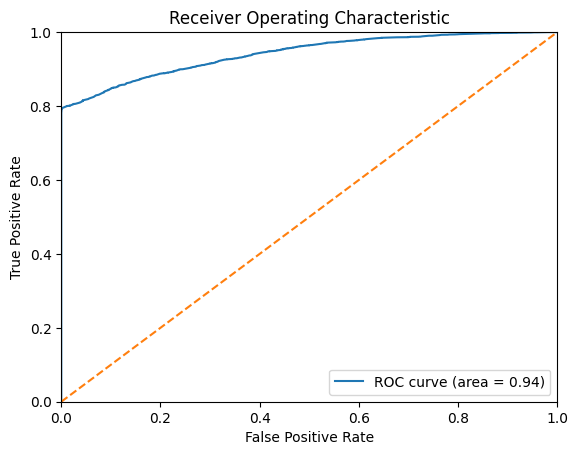

In [15]:
# 訓練データ全体でモデルを再訓練
model.fit(X_train, t_train)

# テストデータでの予測
test_predictions = model.predict_proba(X_test)[:, 1]

# テストデータでのAUC評価
test_auc = roc_auc_score(t_test, test_predictions)
print(f'AUC (CVあり): {test_auc}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test)
score_cv = accuracy_score(t_test, test_preds_binary)
precision_cv = precision_score(t_test, test_preds_binary)
recall_cv = recall_score(t_test, test_preds_binary)
f1_cv = f1_score(t_test, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

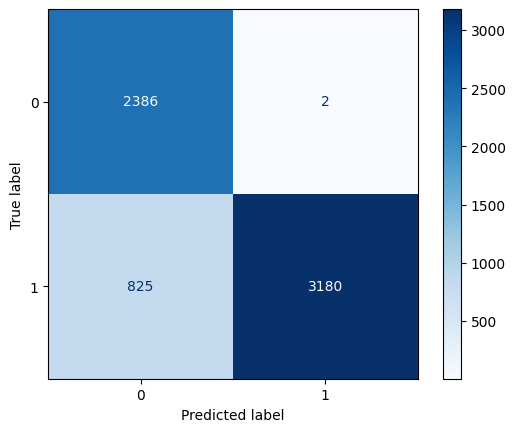

In [16]:
# 混同行列
cm = confusion_matrix(t_test, test_preds_binary)
cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmp.plot(cmap=plt.cm.Blues)

**グリットサーチによるハイパーパラメータの選定**

In [17]:
#グリッドサーチに必要なライブラリ
from sklearn.model_selection import GridSearchCV

In [18]:
search_params = {
    'n_estimators':[10, 30, 50, 70],
    'max_features':["sqrt", "log2", None],
    'max_depth':[5, 10, 30, None],
}

X_train, X_test, t_train, t_test = train_test_split(
    df_RF_YesKoupon[["recency", "history", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

gsr = GridSearchCV(
    RandomForestClassifier(random_state=42),
    search_params,
    cv = 3,
    scoring = 'roc_auc',
    verbose=True
)

#モデルの最適なパラメータで重み付けを学習
gsr.fit(X_train, t_train)

#モデルの最適なパラメータ
print('Best Pramas:',gsr.best_estimator_)
#最適なパラメータのスコア
print('Best Score:',gsr.best_score_)




Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Pramas: RandomForestClassifier(max_depth=5, max_features=None, n_estimators=70,
                       random_state=42)
Best Score: 0.9428949543573643


In [19]:
search_params = {
    'n_estimators':[70, 100, 150, 200],
    'max_features':[None],
    "criterion":['gini', 'entropy'],
    'max_depth':[5, 10, 30, None],
}

X_train, X_test, t_train, t_test = train_test_split(
    df_RF_YesKoupon[["recency", "history", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

gsr = GridSearchCV(
    RandomForestClassifier(random_state=42),
    search_params,
    cv = 3,
    scoring = 'roc_auc',
    verbose=True
)

#モデルの最適なパラメータで重み付けを学習
gsr.fit(X_train, t_train)

#モデルの最適なパラメータ
print('Best Pramas:',gsr.best_estimator_)
#最適なパラメータのスコア
print('Best Score:',gsr.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Pramas: RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       n_estimators=150, random_state=42)
Best Score: 0.9430084801259359


以上の結果よりハイパーパラメータは[criterion='entropy', max_depth=5, max_features=None,n_estimators=150]とすると94%の精度で予測が可能

**ここからクーポンなしの実装**

AUC (CVあり): 0.7282485374026122
正解率 (CVあり): 69.20%
適合率 (CVあり): 57.78%
再現率 (CVあり): 21.17%
F1 (CVあり): 30.98%


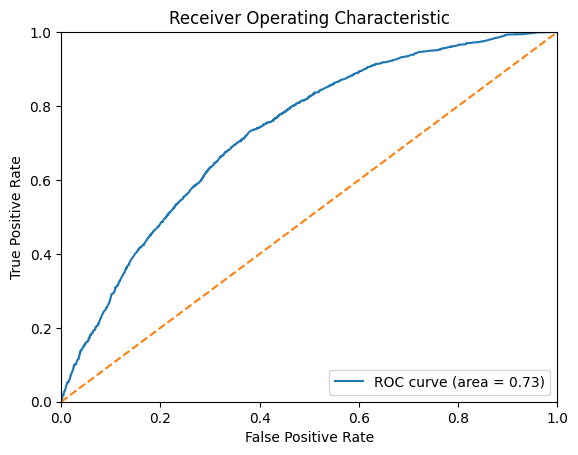

In [20]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train, X_test, t_train, t_test = train_test_split(
    df_RF_NoKoupon[["recency", "history", "newbie"]],
    df_RF_NoKoupon["visit"],
    test_size=0.3,
    random_state=0
)

#選定したハイパーパラメータのモデル
model = RandomForestClassifier(random_state=42,
                               criterion='entropy',
                               max_depth=5,
                               max_features=None,
                               n_estimators=150)

# 訓練データ全体でモデルを再訓練
model.fit(X_train, t_train)

# テストデータでの予測
test_predictions = model.predict_proba(X_test)[:, 1]

# テストデータでのAUC評価
test_auc = roc_auc_score(t_test, test_predictions)
print(f'AUC (CVあり): {test_auc}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test)
score_cv = accuracy_score(t_test, test_preds_binary)
precision_cv = precision_score(t_test, test_preds_binary)
recall_cv = recall_score(t_test, test_preds_binary)
f1_cv = f1_score(t_test, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()